In [6]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *

#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('../lib/data_v4/v_grid.txt')
CCF     = np.loadtxt('../lib/data_v4/CCF.txt')
σCCF   = np.loadtxt('../lib/data_v4/σCCF.txt')
bjd     = np.loadtxt('../lib/data_v4/bjd.txt')
rv      = np.loadtxt('../lib/data_v4/rv.txt')
σrv     = np.loadtxt('../lib/data_v4/σrv.txt')


In [3]:
rv.shape

(31795,)

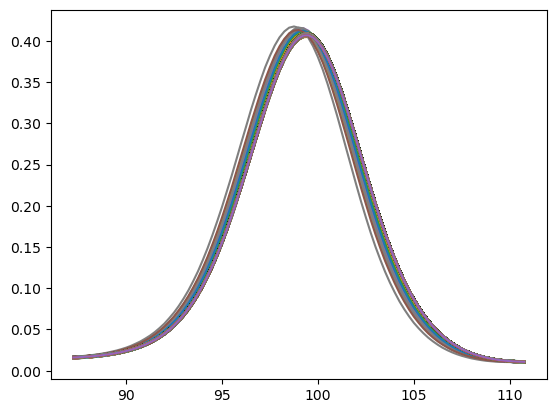

In [4]:
plt.plot(v_grid, CCF)
plt.show()

In [7]:
#==============================================================================
# Feed CCFs into FIESTA
#==============================================================================
df, shift_spectrum, err_shift_spectrum, power_spectrum, err_power_spectrum, RV_gauss = FIESTA(v_grid, CCF, σCCF, k_max=6)
shift_spectrum      *= 1000
err_shift_spectrum  *= 1000
RV_gauss            *= 1000
shift_function      = np.zeros(shift_spectrum.shape)

for i in range(shift_spectrum.shape[0]):
    shift_function[i,:] = shift_spectrum[i,:] - RV_gauss # look back; change rv_raw_daily




Velocity grid used [87.25, 110.75]

ξ_normal = 0.67


The median SNR of all CCFs is 5999
ξ_modelling_noise = 1.26


Based on the user-defined SNR = 2.0:
ξ_individual = 1.98
ξ_timeseries = 0.13

In summary, the cut-off frequency for FIESTA is recommended to be 0.13 (3 frequency modes)

        ξ  individual_SNR  ts_SNR_A  ts_SNR_ϕ  modelling noise  \
0   0.000         13382.5      27.5       0.0          0.13662   
1   0.042          8502.2      10.3     931.8          0.04870   
2   0.084          3145.1       4.5      12.4          0.01186   
3   0.126           772.9       2.5      77.9          0.00243   
4   0.168           158.0       1.3       1.5          0.00055   
5   0.211            11.9       1.0      19.4          0.00052   
6   0.253            16.4       0.9       0.9          0.00045   
7   0.295            11.1       0.9       0.8          0.00042   
8   0.337            10.1       0.8       0.8          0.00039   
9   0.379             8.8       0.7       0.7        

In [10]:
np.savetxt('../lib/data_v4/RV_gauss.txt', RV_gauss)

In [11]:
#----------------------------------
# Plot the RVs 
#----------------------------------

def plot_rv(date1, date2):
    plt.rcParams.update({'font.size': 14})
    alpha   = 0.3
    colors  = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                  '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                  '#bcbd22', '#17becf']

    idx_bjd = (bjd>date1) & (bjd<date2+1)

    fig, axes = plt.subplots(figsize=(15, 3))
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.errorbar(bjd[idx_bjd]-2400000, rv[idx_bjd]-np.mean(rv[idx_bjd]), σrv[idx_bjd], c='red', marker='.', ls='none', alpha=alpha, label='rv')
    plt.errorbar(bjd[idx_bjd]-2400000, RV_gauss[idx_bjd]-np.mean(RV_gauss[idx_bjd]), σrv[idx_bjd], c='blue', marker='.', ls='none', alpha=alpha, label='RV_gauss')
    plt.legend()
    plt.xlabel('BJD - 2400000 [d]')
    plt.ylabel('RV [m/s]')

    if date1 == date2:
        filename = '%d.%d.%d' %(tuple(pyasl.daycnv(date1))[:3])
        plt.title('%d.%d.%d' %tuple(pyasl.daycnv(date1))[:3])
    else:
        filename = '%d.%d.%d-%d.%d.%d' %(tuple(pyasl.daycnv(date1))[:3]+tuple(pyasl.daycnv(date2))[:3])
        plt.title(filename)
    plt.savefig('./figure/' + filename+'.png')
    plt.show()


### RVs

In [12]:
import pandas as pd
df  = pd.read_csv('../lib/full_combined_rvs_1.csv')
df_daily = pd.read_csv('../lib/summary_1.csv')
bjd_daily = df_daily['obs_date.mean_bjd']

rv_by_order = df.iloc[:,164:].values * 1000
rv_drp = df['rv_drp']*1000
rv_template = df['rv_template']

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=1)
    # Fast and numerically precise:
    variance = np.average(((np.subtract(values.T,average))**2).T, weights=weights, axis=1)
    return (average, np.sqrt(variance))

# ave, rms_by_obs = weighted_avg_and_std(values=rv_by_order, weights=1/σrv**2)



FileNotFoundError: [Errno 2] No such file or directory: 'full_combined_rvs_1.csv'

rv statistics by order 

### exclude bad observations (days)

#### reject rvs lie outside 2-sigma rv

In [8]:
def weighted_avg_and_std2(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

_, rv_drp_std = weighted_avg_and_std2(rv_drp, 1/σrv**2)

In [9]:
rv_drp_median = np.median(rv_drp)
idx_rej_1sigma = abs(rv_drp-np.median(rv_drp)) > (2*rv_drp_std)
sum(idx_rej_1sigma)

101

#### reject rvs on user-defined dates

In [10]:
dates_to_exclude = [datetime(2021, 6, 4), datetime(2021, 6, 16), datetime(2021, 7, 9), datetime(2021, 7, 10), datetime(2021, 7, 18), datetime(2021, 7, 19)]

idx_rej_bjd = np.zeros(bjd.shape, dtype=bool)

# use pyasl.jdcnv(date)+1 to translate to the corresponding bjd
for date in dates_to_exclude:
    idx = (abs(bjd-pyasl.jdcnv(date)-1)<0.5)
    idx_rej_bjd = idx_rej_bjd | idx
    print(sum(idx))
    
sum(idx_rej_bjd)

82
89
22
191
25
9


418

#### reject days with few observations (<10)

In [11]:
idx_rej_fewobs = np.zeros(bjd.shape, dtype=bool)
obs_date = df_daily['obs_date.string']

for i in range(len(obs_date)):
    if df_daily['num_rvs.good'][i] < 10:
        date = datetime(int(obs_date[i][0:4]), int(obs_date[i][5:7]), int(obs_date[i][8:10]))
        idx = (abs(bjd-pyasl.jdcnv(date)-1)<0.5)
        idx_rej_fewobs = idx_rej_fewobs | idx
#         print(sum(idx))
sum(idx_rej_fewobs)

225

#### only use 59260< bjd-2400000 < 59500

In [12]:
idx_rej_bjd2 = ((bjd-2400000)> 59500) | ((bjd-2400000)<59260)
sum(idx_rej_bjd2)

13206

#### all rejects

In [14]:
idx_rej = idx_rej_1sigma | idx_rej_bjd | idx_rej_fewobs #| idx_rej_bjd2
# idx_rej = idx_rej_bjd | idx_rej_fewobs #| idx_rej_bjd2
len(idx_rej), sum(idx_rej)

(31795, 650)

In [15]:
np.savetxt('idx_rej', idx_rej)

In [14]:
if 0:
    fig, axes = plt.subplots(figsize=(15, 3))
    alpha=0.05

    plt.plot(bjd-2400000, rv_drp-rv_drp[0], '.', label='rv_drp', alpha=alpha)
    # plt.plot(bjd-2400000, rv_template-rv_template[0], '.', label='rv_template', alpha=alpha)
    plt.plot(bjd-2400000, RV_gauss-RV_gauss[0], '.', label='RV_gauss', alpha=alpha)

    plt.legend()
    plt.xlabel('BJD - 2400000 [d]')
    plt.ylabel('m/s')
    plt.ylim(-25,5)
    plt.show()

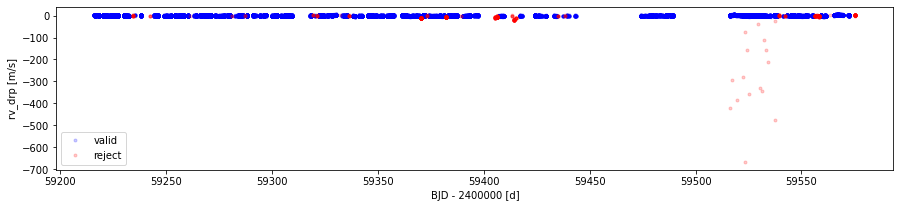

In [15]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.2
plt.plot(bjd[~idx_rej]-2400000, rv_drp[~idx_rej]-rv_drp_median, 'b.', label='valid', alpha=alpha)
plt.plot(bjd[idx_rej]-2400000, rv_drp[idx_rej]-rv_drp_median, 'r.', label='reject', alpha=alpha)
plt.legend()
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('rv_drp [m/s]')
plt.show()

zoom in y-axis

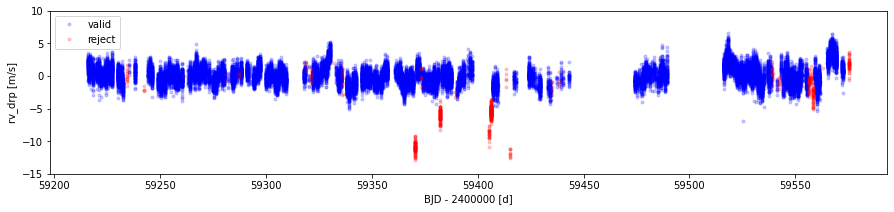

In [16]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.2
plt.plot(bjd[~idx_rej]-2400000, rv_drp[~idx_rej]-rv_drp_median, 'b.', label='valid', alpha=alpha)
plt.plot(bjd[idx_rej]-2400000, rv_drp[idx_rej]-rv_drp_median, 'r.', label='reject', alpha=alpha)
plt.legend()
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('rv_drp [m/s]')
plt.ylim(-15,10)
plt.show()

zoom in x-axis

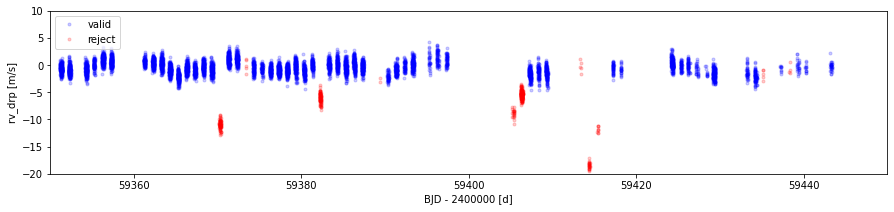

In [17]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.2
plt.plot(bjd[~idx_rej]-2400000, rv_drp[~idx_rej]-rv_drp_median, 'b.', label='valid', alpha=alpha)
plt.plot(bjd[idx_rej]-2400000, rv_drp[idx_rej]-rv_drp_median, 'r.', label='reject', alpha=alpha)
# plt.plot(bjd-2400000, (df['CaIIHK']-np.mean(df['CaIIHK']))*5000+10, 'k.', label='CaIIHK', alpha=alpha)
plt.legend(loc=2)
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('rv_drp [m/s]')
plt.xlim(59350,59450)
# plt.xlim(59550,59680)
plt.ylim(-20,10)
plt.show()

## Plots 

In [18]:

def plot_all(k_mode, t, rv, erv, ind, eind, ts_xlabel, rv_xlabel, pe_xlabel, ind_yalbel, file_name):

	'''
	e.g. 
		k_mode 		= 11
		t 			= bjd_daily
		rv 			= rv_daily
		erv 		= erv_daily
		ind 		= shift_function
		eind 	 	= err_shift_spectrum
		ts_xlabel 	= 'BJD - 2400000 [d]'
		rv_xlabel 	= '$RV_{HARPS}$'
		pe_xlabel 	= 'Period [days]'
		ind_yalbel	= 'A'
		file_name 	= 'time-series_and_shift_correlation.png'

	'''

	def new_periodogram(x, y, dy, height_ratio=0.4, plot_min_t=1.5, max_f=1, spp=100):
	
		from scipy.signal import find_peaks
		from astropy.timeseries import LombScargle

		time_span = (max(x) - min(x))
		min_f   = 1/time_span

		frequency, power = LombScargle(x, y, dy).autopower(minimum_frequency=min_f,
													   maximum_frequency=max_f,
													   samples_per_peak=spp)

		plot_x = 1/frequency
		idxx = (plot_x>plot_min_t) & (plot_x<time_span/2)
		height = max(power[idxx])*height_ratio
		ax.plot(plot_x[idxx], power[idxx], 'k-', alpha=0.5)
		peaks, _ = find_peaks(power[idxx], height=height)
		ax.plot(plot_x[idxx][peaks], power[idxx][peaks], "ro")

		for n in range(len(plot_x[idxx][peaks])):
			ax.text(plot_x[idxx][peaks][n], power[idxx][peaks][n], '%.1f' % plot_x[idxx][peaks][n], fontsize=10)

		ax.set_xlim([plot_min_t,time_span/2])
		ax.set_ylim([0, 1.2*max(power[idxx])])

		ax.set_xscale('log')


	from sklearn.linear_model import LinearRegression

	# set up the plotting configureations
	alpha1, alpha2 = [0.5,0.2]
	widths 	= [7,1,7]
	heights = [1]*(k_mode+1)
	gs_kw 	= dict(width_ratios=widths, height_ratios=heights)
	plt.rcParams.update({'font.size': 12})
	fig6, f6_axes = plt.subplots(figsize=(16, k_mode+1), ncols=3, nrows=k_mode+1, constrained_layout=True,
	                             gridspec_kw=gs_kw)

	# plots 
	for r, row in enumerate(f6_axes):
		for c, ax in enumerate(row):	

			# time-series 
			if c==0:
				if r==0:
					ax.errorbar(t, rv-np.mean(rv), erv, marker='.', ms=5, color='black', ls='none', alpha=alpha1)
					ax.set_title('Time-series')
					ax.set_ylabel(rv_xlabel)
				else:				
					ax.errorbar(t, ind[r-1,:], eind[r-1,:],  marker='.', ms=5, color='black', ls='none', alpha=alpha1)
					ax.set_ylabel(ind_yalbel + '$_{' + str(r) + '}$')
				if r!=k_mode:
					ax.set_xticks([])
				else:
					ax.set_xlabel(ts_xlabel)

			if c==1:
				if r==0:
					reg = LinearRegression().fit(rv.reshape(-1, 1), rv.reshape(-1, 1))
					score = reg.score(rv.reshape(-1, 1), rv.reshape(-1, 1))
					adjust_R2 = 1-(1-score)*(len(t)-1)/(len(t)-1-1)
					title = r'$\bar{R}$' + r'$^2$'
					ax.set_title(title + ' = {:.2f}'.format(adjust_R2))					
					ax.plot(rv-np.mean(rv), rv-np.mean(rv), 'k.', alpha = alpha2)				
				if r>0:
					reg = LinearRegression().fit(rv.reshape(-1, 1), ind[r-1,:].reshape(-1, 1))
					score = reg.score(rv.reshape(-1, 1), ind[r-1,:].reshape(-1, 1))
					adjust_R2 = 1-(1-score)*(len(t)-1)/(len(t)-1-1)
					title = r'$\bar{R}$' + r'$^2$'
					ax.set_title(title + ' = {:.2f}'.format(adjust_R2))
					ax.plot(rv-np.mean(rv), ind[r-1,:], 'k.', alpha = alpha2)
				if r!=k_mode:
					ax.set_xticks([])
				else:
					ax.set_xlabel(rv_xlabel)
				ax.yaxis.tick_right()

			if c==2:
				if r==0:
					new_periodogram(t, rv, erv)
					ax.set_title('Periodogram')
				if r>0:
					new_periodogram(t, ind[r-1,:], eind[r-1,:])
				if r!=k_mode:
					ax.set_xticks([])
				if r==k_mode:
					ax.set_xlabel(pe_xlabel)
	if file_name !=[]:
		plt.savefig(file_name)

### amplitudes and $\Delta RV$

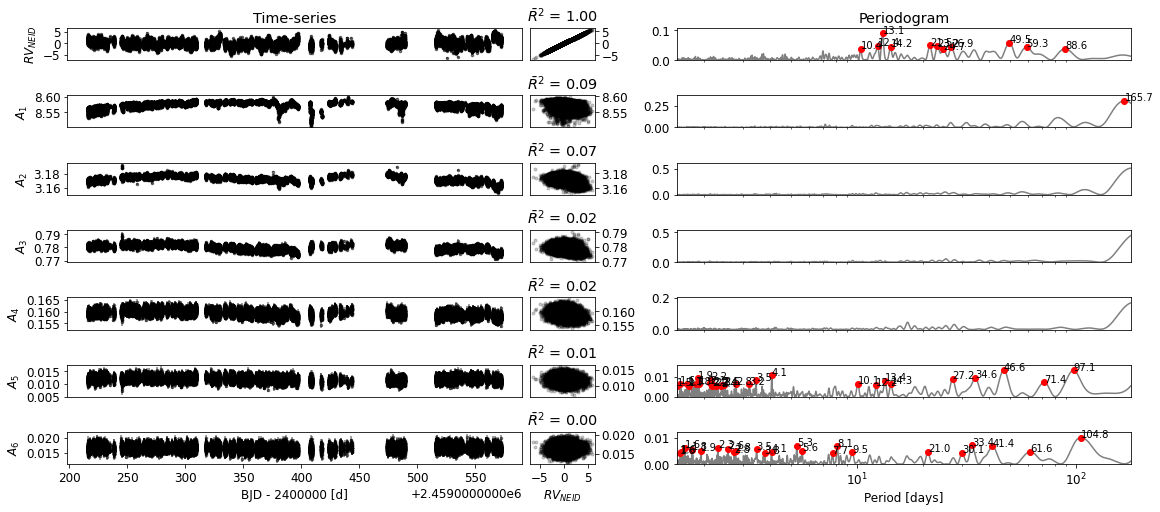

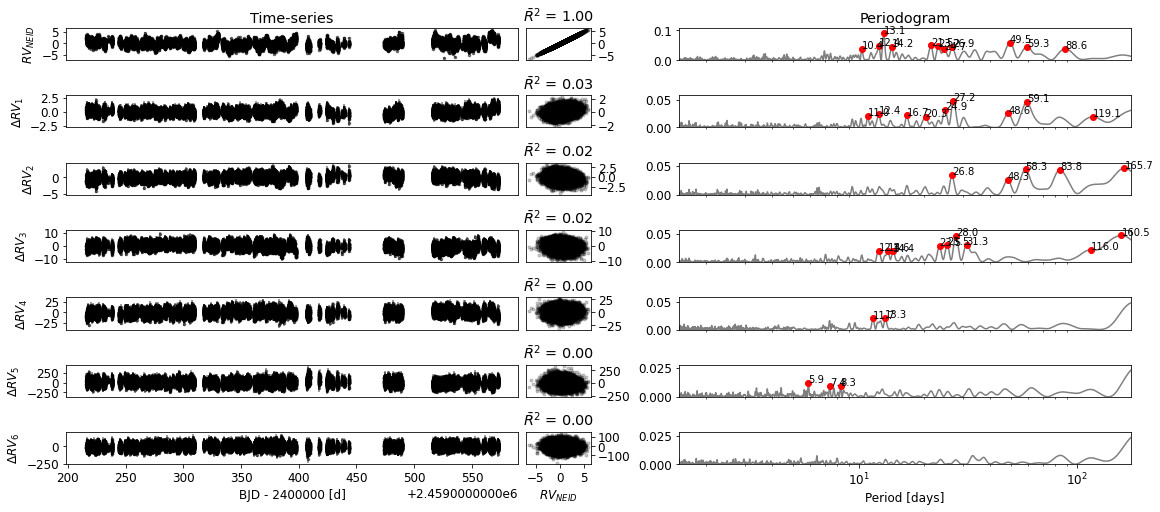

In [19]:
T1      = pyasl.jdcnv(datetime(2021, 1, 1))
T2      = pyasl.jdcnv(datetime(2021, 12, 31))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plt.rcParams.update({'font.size': 14})
plot_all(k_mode=6, t=bjd[idx_bjd], rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd], 
    ind=power_spectrum[:,idx_bjd], eind=err_power_spectrum[:,idx_bjd], 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$A$',
    file_name='./figure/' + 'Amplitude_time-series_correlation_periodogram_NEID_0101-1231.pdf')
plt.show()

plot_all(k_mode=6, t=bjd[idx_bjd], rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0101-1231.pdf')
plt.show()

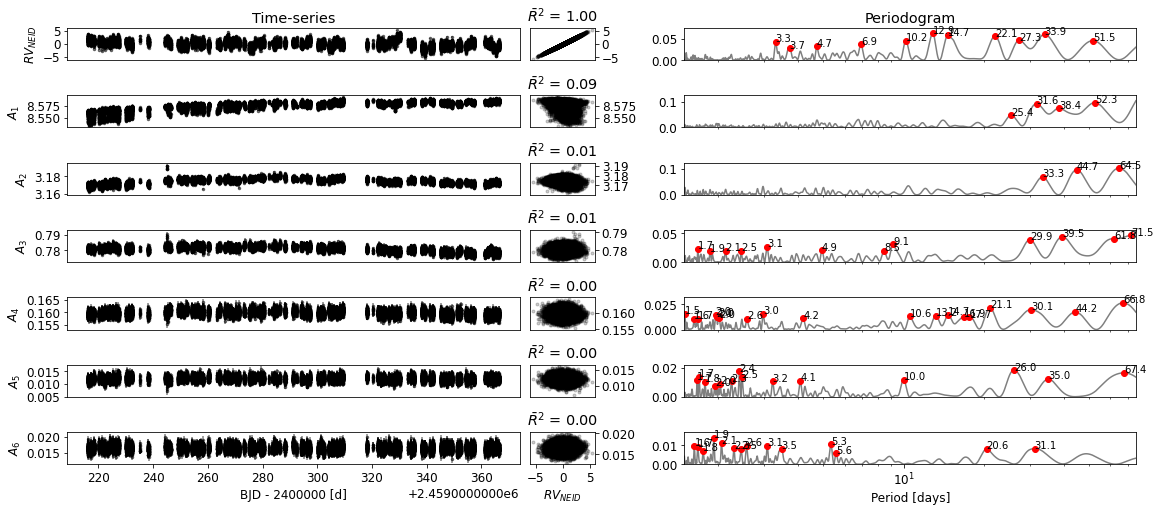

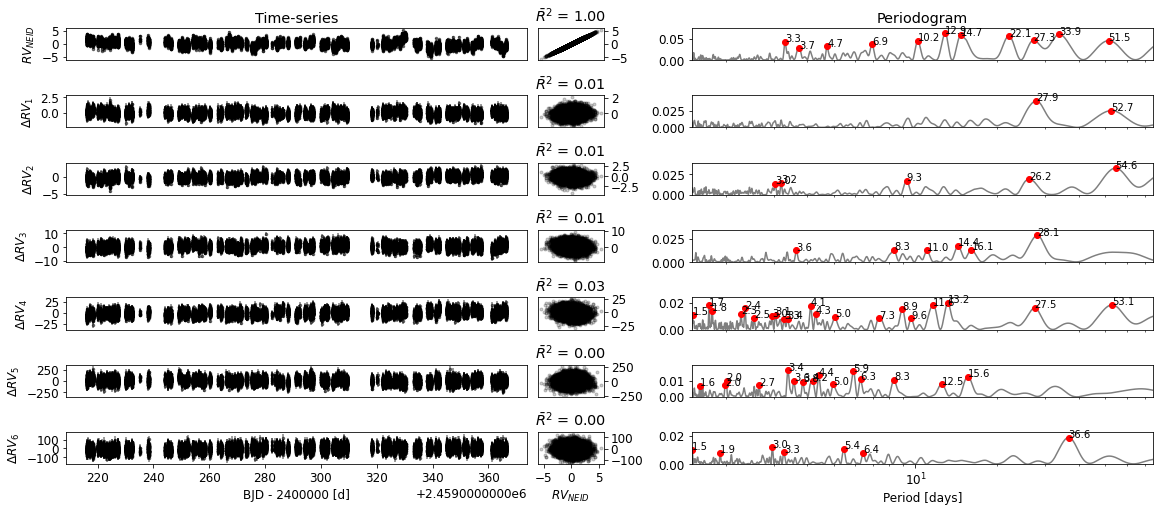

In [20]:
T1      = pyasl.jdcnv(datetime(2021, 1, 1))
T2      = pyasl.jdcnv(datetime(2021, 5, 31))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plt.rcParams.update({'font.size': 14})
plot_all(k_mode=6, t=bjd[idx_bjd], rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd], 
    ind=power_spectrum[:,idx_bjd], eind=err_power_spectrum[:,idx_bjd], 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$A$',
    file_name='./figure/' + 'Amplitude_time-series_correlation_periodogram_NEID_0101-0531.pdf')
plt.show()

plot_all(k_mode=6, t=bjd[idx_bjd], rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0101-0531.pdf')
plt.show()

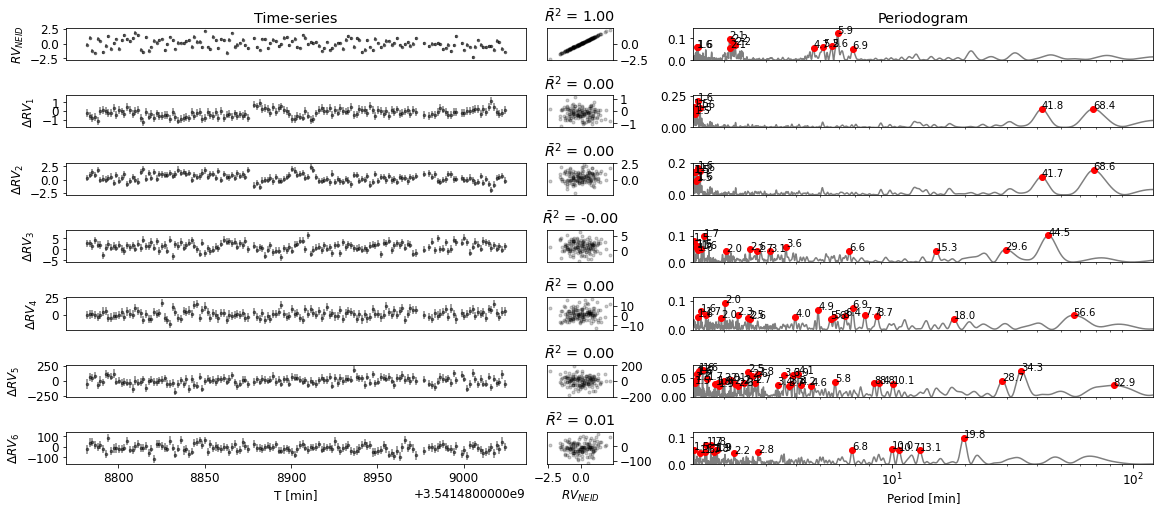

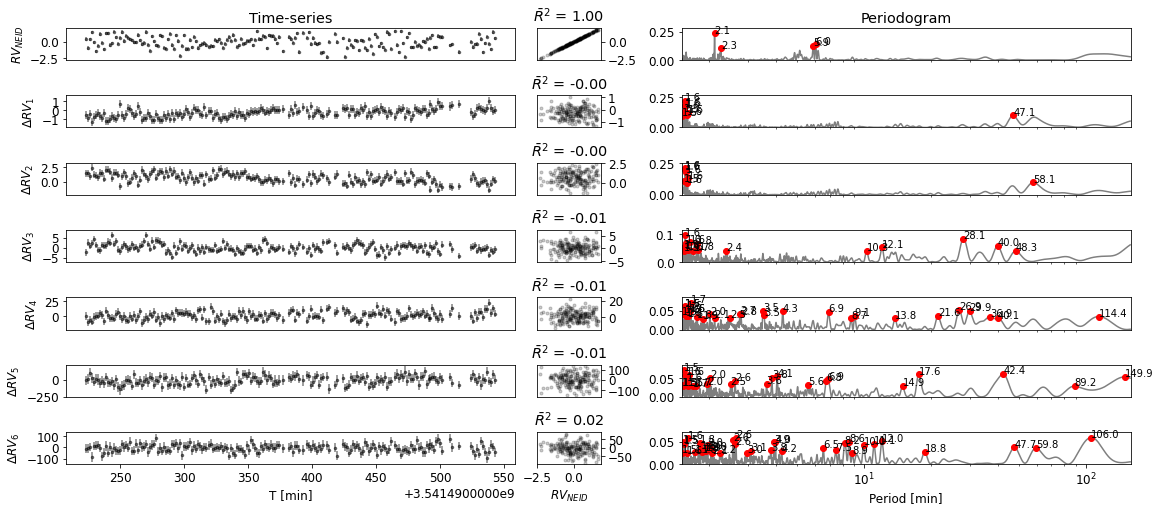

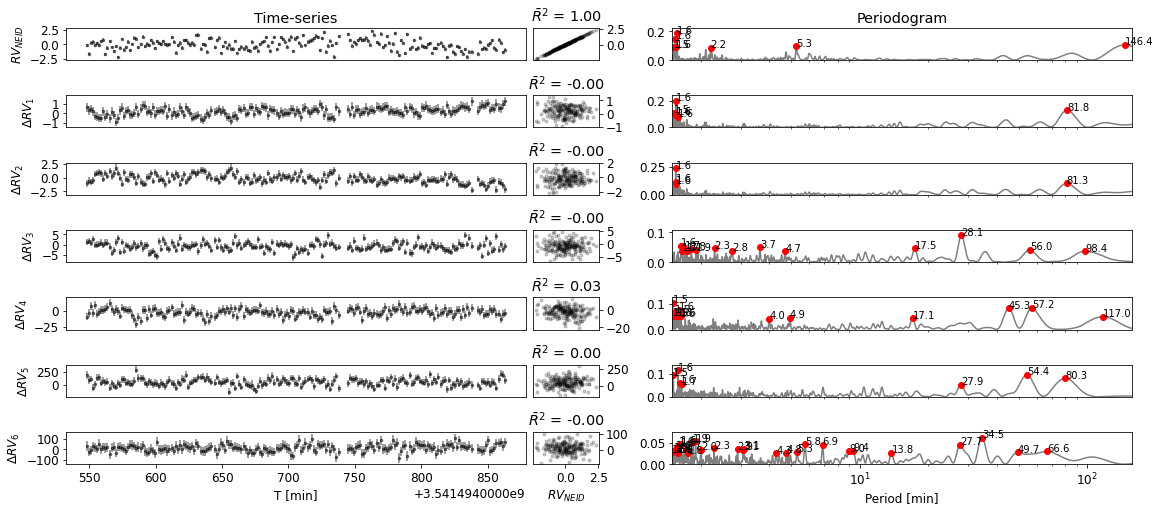

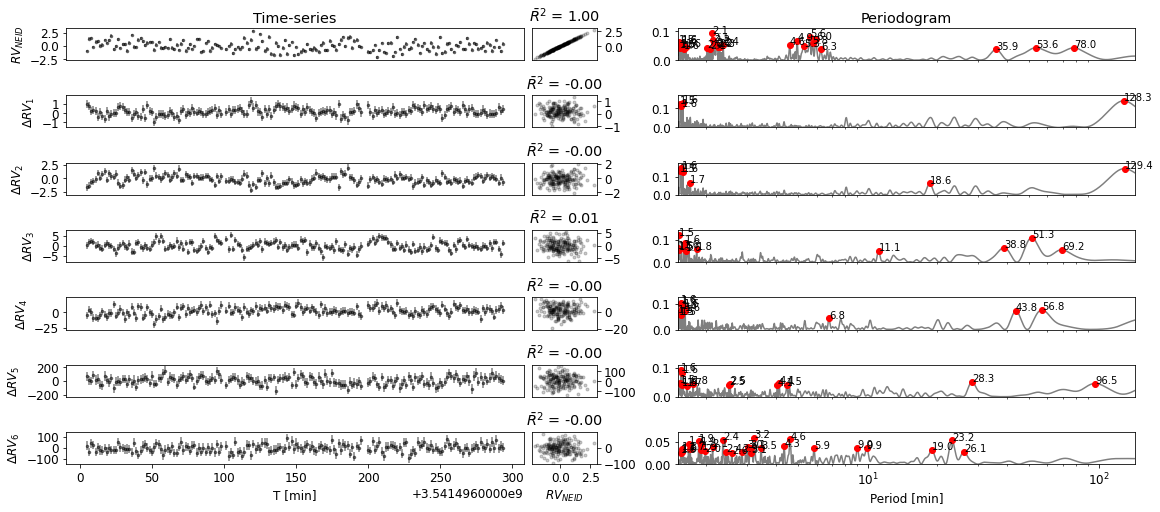

In [21]:
T1      = pyasl.jdcnv(datetime(2021, 6, 1))
T2      = pyasl.jdcnv(datetime(2021, 6, 1))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plt.rcParams.update({'font.size': 14})
# plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd], 
#     ind=power_spectrum[:,idx_bjd], eind=err_power_spectrum[:,idx_bjd], 
#     ts_xlabel='BJD - 2400000 [d]', 
#     rv_xlabel='$RV_{NEID}$', 
#     pe_xlabel='Period [min]',
#     ind_yalbel=r'$A$',
#     file_name='./figure/' + 'Amplitude_time-series_correlation_periodogram_NEID_0601.pdf')

plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='T [min]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [min]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0601.pdf')

T1      = pyasl.jdcnv(datetime(2021, 6, 2))
T2      = T1
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='T [min]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [min]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0602.pdf')

T1      = pyasl.jdcnv(datetime(2021, 6, 5))
T2      = T1
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='T [min]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [min]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0605.pdf')

T1      = pyasl.jdcnv(datetime(2021, 6, 6))
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='T [min]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [min]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0606.pdf')

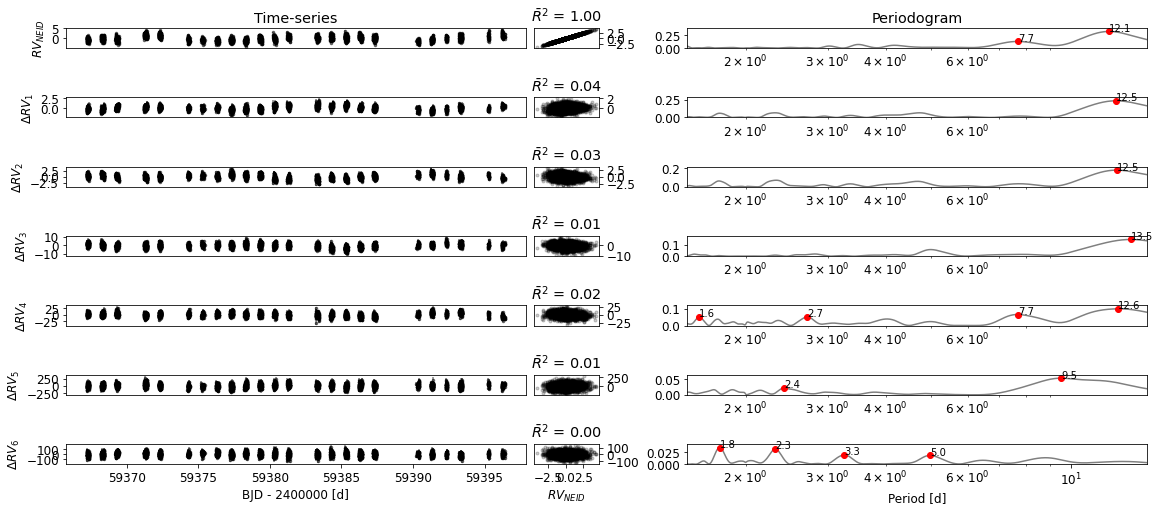

In [22]:
T1      = pyasl.jdcnv(datetime(2021, 6, 1))
T2      = pyasl.jdcnv(datetime(2021, 6, 30))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plt.rcParams.update({'font.size': 14})
# plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd], 
#     ind=power_spectrum[:,idx_bjd], eind=err_power_spectrum[:,idx_bjd], 
#     ts_xlabel='BJD - 2400000 [d]', 
#     rv_xlabel='$RV_{NEID}$', 
#     pe_xlabel='Period [min]',
#     ind_yalbel=r'$A$',
#     file_name='./figure/' + 'Amplitude_time-series_correlation_periodogram_NEID_0601.pdf')

plot_all(k_mode=6, t=bjd[idx_bjd]-2400000, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [d]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_06.pdf')

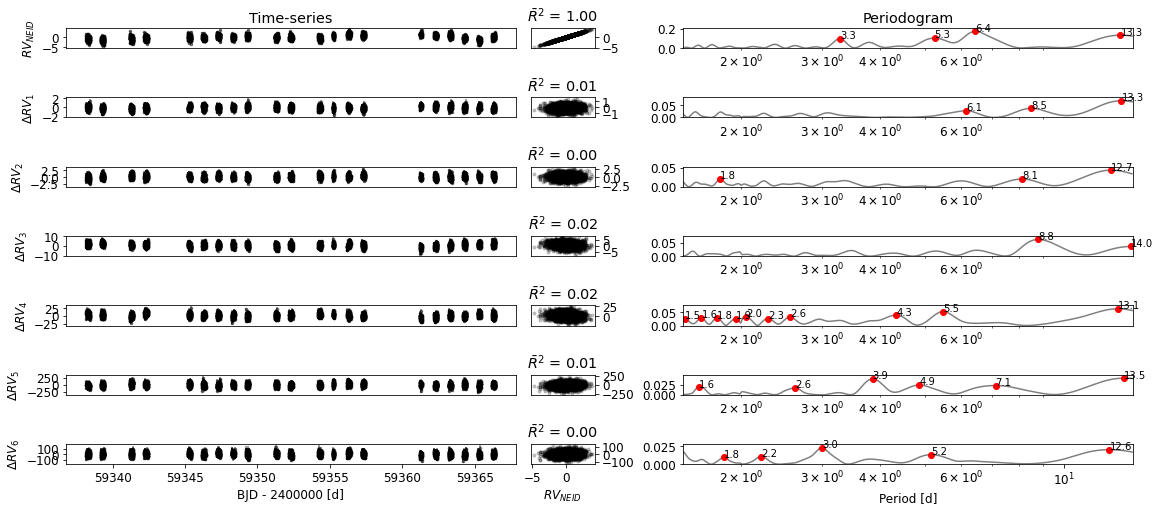

In [23]:
T1      = pyasl.jdcnv(datetime(2021, 5, 1))
T2      = pyasl.jdcnv(datetime(2021, 5, 31))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

plt.rcParams.update({'font.size': 14})
# plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd], 
#     ind=power_spectrum[:,idx_bjd], eind=err_power_spectrum[:,idx_bjd], 
#     ts_xlabel='BJD - 2400000 [d]', 
#     rv_xlabel='$RV_{NEID}$', 
#     pe_xlabel='Period [min]',
#     ind_yalbel=r'$A$',
#     file_name='./figure/' + 'Amplitude_time-series_correlation_periodogram_NEID_0601.pdf')

plot_all(k_mode=6, t=bjd[idx_bjd]-2400000, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
    ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{NEID}$', 
    pe_xlabel='Period [d]',
    ind_yalbel=r'$\Delta RV$',
    file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_05.pdf')

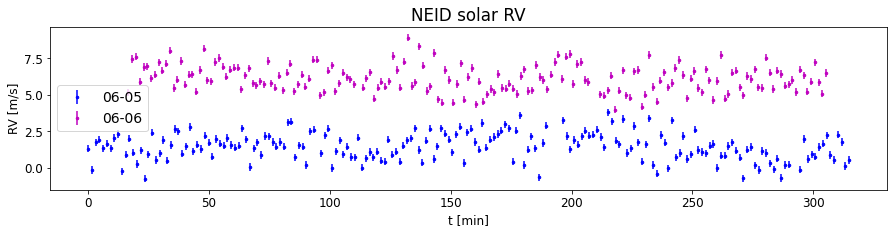

In [24]:
T1      = pyasl.jdcnv(datetime(2021, 6, 5))
idx_bjd5 = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

T1      = pyasl.jdcnv(datetime(2021, 6, 6))
idx_bjd6 = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

plt.subplots(figsize=(15, 3))
plt.rcParams.update({'font.size': 14})
plt.errorbar((bjd[idx_bjd5]-min(bjd[idx_bjd5]))*24*60, RV_gauss[idx_bjd5], σrv[idx_bjd5], marker='.', ms=5, color='blue', ls='none', label='06-05')
plt.errorbar((bjd[idx_bjd6]-min(bjd[idx_bjd5])-1)*24*60, RV_gauss[idx_bjd6]+5, σrv[idx_bjd6], marker='.', ms=5, color='m', ls='none', label='06-06')
plt.title('NEID solar RV')
plt.xlabel('t [min]')
plt.ylabel('RV [m/s]')
plt.legend()
plt.show()

# plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
#     ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
#     ts_xlabel='T [min]', 
#     rv_xlabel='$RV_{NEID}$', 
#     pe_xlabel='Period [min]',
#     ind_yalbel=r'$\Delta RV$',
#     file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0605.pdf')

# T1      = pyasl.jdcnv(datetime(2021, 6, 6))
# idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

# plot_all(k_mode=6, t=bjd[idx_bjd]*24*60, rv=RV_gauss[idx_bjd], erv=σrv[idx_bjd],  
#     ind=shift_function[:,idx_bjd], eind=err_shift_spectrum[:,idx_bjd], 
#     ts_xlabel='T [min]', 
#     rv_xlabel='$RV_{NEID}$', 
#     pe_xlabel='Period [min]',
#     ind_yalbel=r'$\Delta RV$',
#     file_name='./figure/' + 'shift_time-series_correlation_periodogram_NEID_0606.pdf')

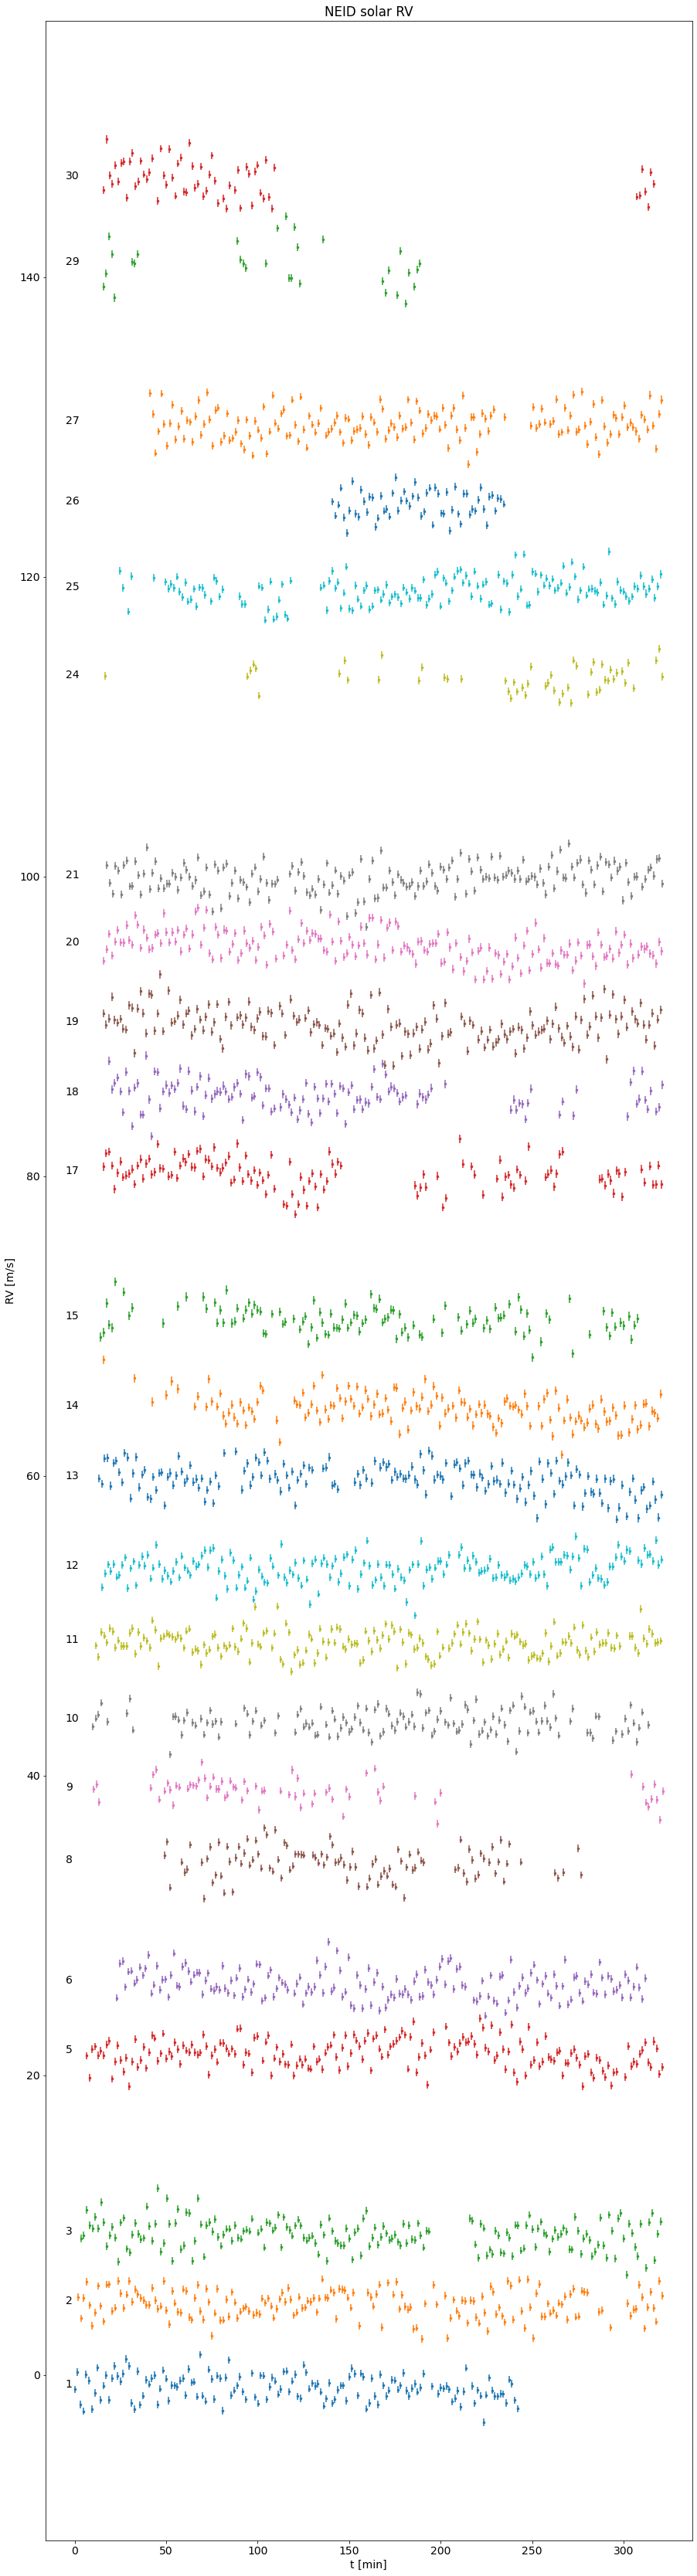

In [47]:
plt.subplots(figsize=(15, 60))
plt.rcParams.update({'font.size': 14})

for t in range(30):
    T1 = pyasl.jdcnv(datetime(2021, 6, t+1))
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    if t==0:
        idx_bjd0 = idx_bjd
    if sum(bjd[idx_bjd])!=0:
        plt.errorbar((bjd[idx_bjd]-min(bjd[idx_bjd0])-t)*24*60, RV_gauss[idx_bjd]+5*t, σrv[idx_bjd], marker='.', ms=5, ls='none', label=str(t))
        plt.text(-5, np.mean(RV_gauss[idx_bjd]+5*t), str(t+1))
        plt.title('NEID solar RV')
        plt.xlabel('t [min]')
        plt.ylabel('RV [m/s]')
plt.show()

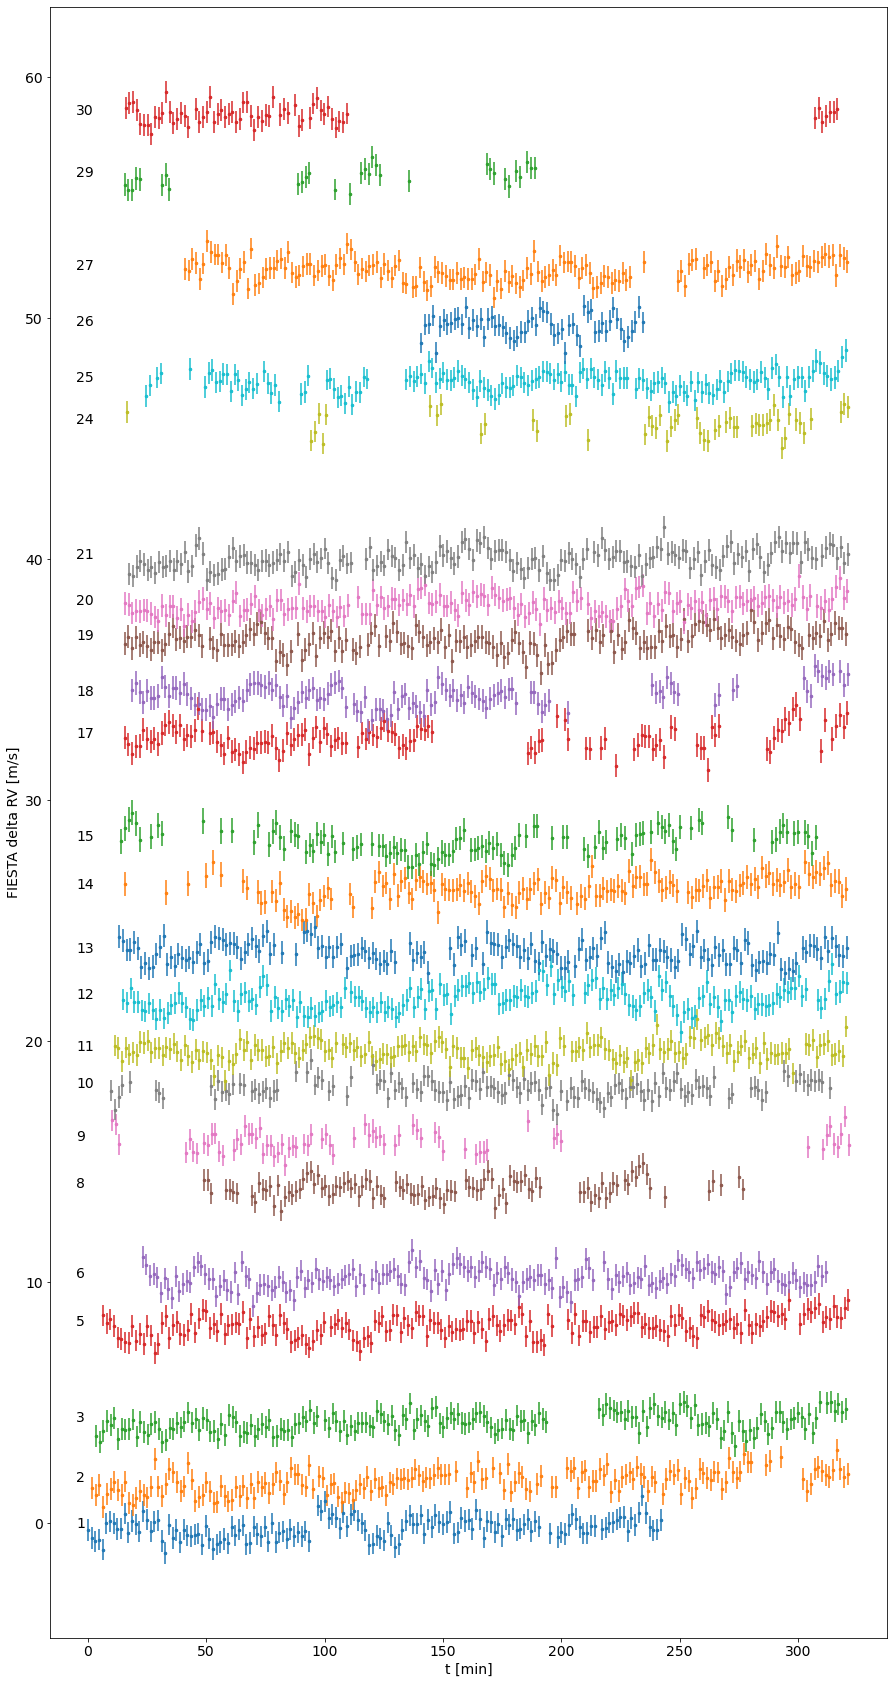

In [26]:
plt.subplots(figsize=(15, 30))
plt.rcParams.update({'font.size': 14})

for t in range(30):
    T1 = pyasl.jdcnv(datetime(2021, 6, t+1))
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    if t==0:
        idx_bjd0 = idx_bjd
    if sum(bjd[idx_bjd])!=0:
        plt.errorbar((bjd[idx_bjd]-min(bjd[idx_bjd0])-t)*24*60, shift_function[0,idx_bjd]+2*t, err_shift_spectrum[0,idx_bjd], marker='.', ms=5, ls='none', label=str(t))
        plt.text(-5, np.mean(shift_function[0,idx_bjd]+2*t), str(t+1))
        # plt.title('NEID solar RV')
        plt.xlabel('t [min]')
        plt.ylabel('FIESTA delta RV [m/s]')
plt.show()

In [27]:
from sklearn.linear_model import Lasso

T1      = pyasl.jdcnv(datetime(2021, 6, 5))
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

feature_matrix = shift_function[0:6,idx_bjd].T
target_vector  = RV_gauss[idx_bjd]
etarget_vector = σrv[idx_bjd]

lasso 	= Lasso(alpha=0.00001, max_iter=10000).fit(feature_matrix, target_vector, sample_weight=1/etarget_vector**2)

y_hat 			= lasso.predict(feature_matrix)
_, w_std_all 	= weighted_avg_and_std2(target_vector, 1/etarget_vector**2)
_, res_wrms 	= weighted_avg_and_std2((y_hat - target_vector), weights=1/etarget_vector**2)
_, model_wrms 	= weighted_avg_and_std2(y_hat, weights=1/etarget_vector**2)
score 			= lasso.score(feature_matrix, target_vector, sample_weight=1/etarget_vector**2)
print(score)
n, p 			= len(target_vector), feature_matrix.shape[1]
adjust_R2 		= 1-(1-score)*(n-1)/(n-p-1)
score 			= adjust_R2
score

0.06286880096096692


0.03327518414920794

In [28]:

lasso.coef_,  w_std_all, res_wrms

(array([ 2.82344768e+00,  1.58435969e+00,  1.50585449e-01, -2.14937557e-02,
         8.15759953e-04, -5.21184874e-04]),
 0.929078568000373,
 0.899399496738251)

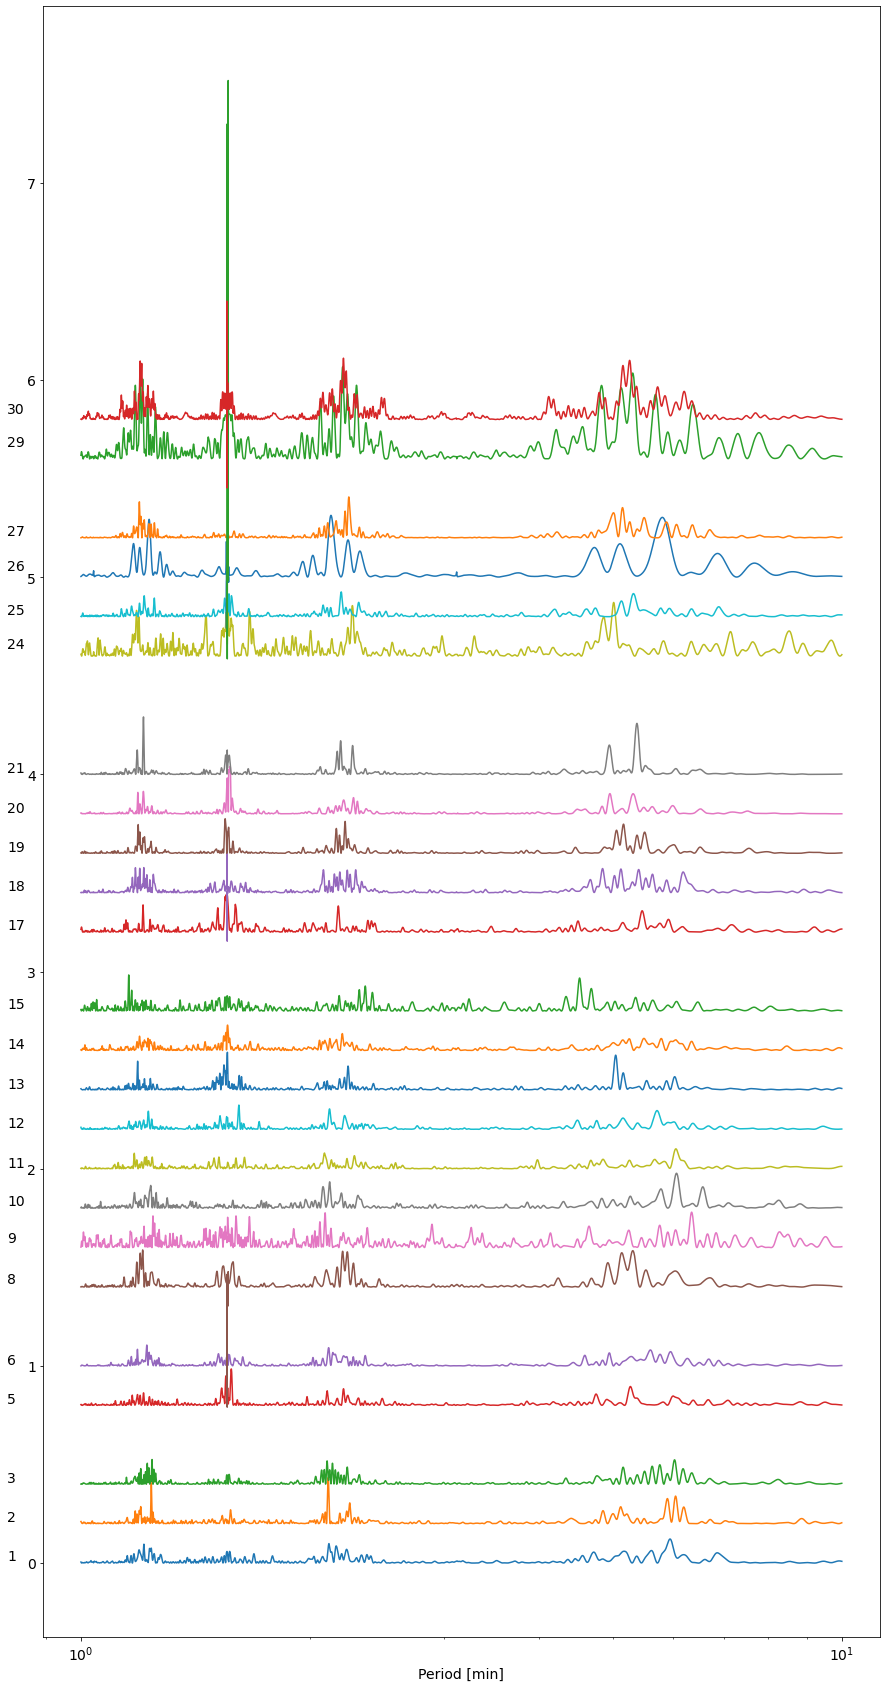

In [29]:
from astropy.timeseries import LombScargle
power_sum = np.zeros(29986)

plt.subplots(figsize=(15, 30))
plt.rcParams.update({'font.size': 14})

for t in range(30):
    T1 = pyasl.jdcnv(datetime(2021, 6, t+1))
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    if t==0:
        idx_bjd0 = idx_bjd
    if sum(bjd[idx_bjd])!=0:
        frequency, power = LombScargle(bjd[idx_bjd]*24*60, RV_gauss[idx_bjd], σrv[idx_bjd]).autopower(minimum_frequency=1/400, maximum_frequency=1, samples_per_peak=100)        
        plot_x = 1/frequency
        idx = plot_x<10
        plt.plot(plot_x[idx], power[idx]+0.2*t)
        # print(power[idx].shape)
        # power_sum += power[idx]
        plt.xscale('log')
        plt.text(0.8, np.mean(power[idx]+0.2*t), str(t+1))
        plt.xlabel('Period [min]')
    # plt.plot(power_sum, power_sum+7)
plt.show()

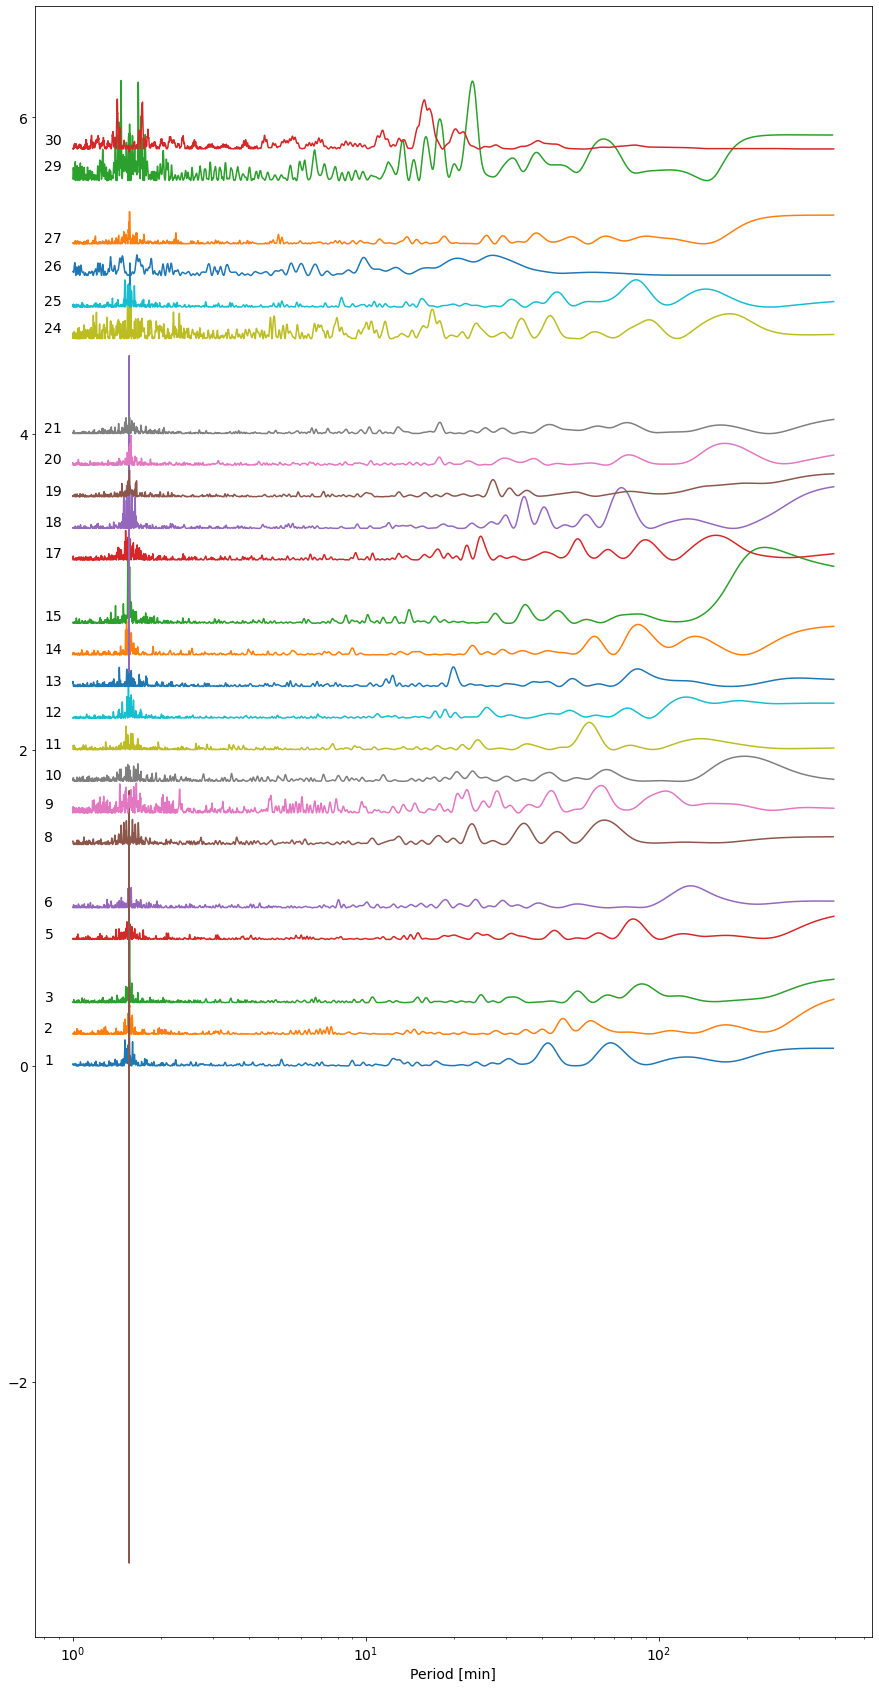

In [30]:
from astropy.timeseries import LombScargle
power_sum = np.zeros(29986)

plt.subplots(figsize=(15, 30))
plt.rcParams.update({'font.size': 14})

for t in range(30):
    T1 = pyasl.jdcnv(datetime(2021, 6, t+1))
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    if t==0:
        idx_bjd0 = idx_bjd
    if sum(bjd[idx_bjd])!=0:
        frequency, power = LombScargle(bjd[idx_bjd]*24*60, shift_function[0,idx_bjd], err_shift_spectrum[0,idx_bjd]).autopower(minimum_frequency=1/400, maximum_frequency=1, samples_per_peak=100)        
        plot_x = 1/frequency
        idx = plot_x<400
        plt.plot(plot_x[idx], power[idx]+0.2*t)
        # print(power[idx].shape)
        # power_sum += power[idx]
        plt.xscale('log')
        plt.text(0.8, np.mean(power[idx]+0.2*t), str(t+1))
        plt.xlabel('Period [min]')
    # plt.plot(power_sum, power_sum+7)
plt.show()

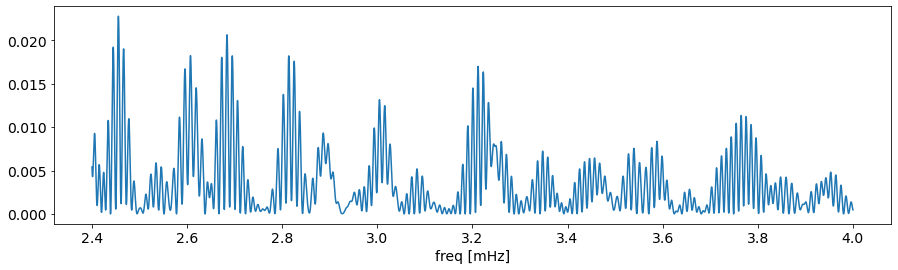

In [32]:
T1      = pyasl.jdcnv(datetime(2021, 6, 1))
T2      = pyasl.jdcnv(datetime(2021, 6, 2))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

frequency, power = LombScargle(bjd[idx_bjd]*24*60, shift_function[0,idx_bjd], err_shift_spectrum[0,idx_bjd]).autopower(minimum_frequency=1/(24*60*30), maximum_frequency=1, samples_per_peak=100)        

plt.subplots(figsize=(15, 4))
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx])
plt.xlabel('freq [mHz]')
plt.show()

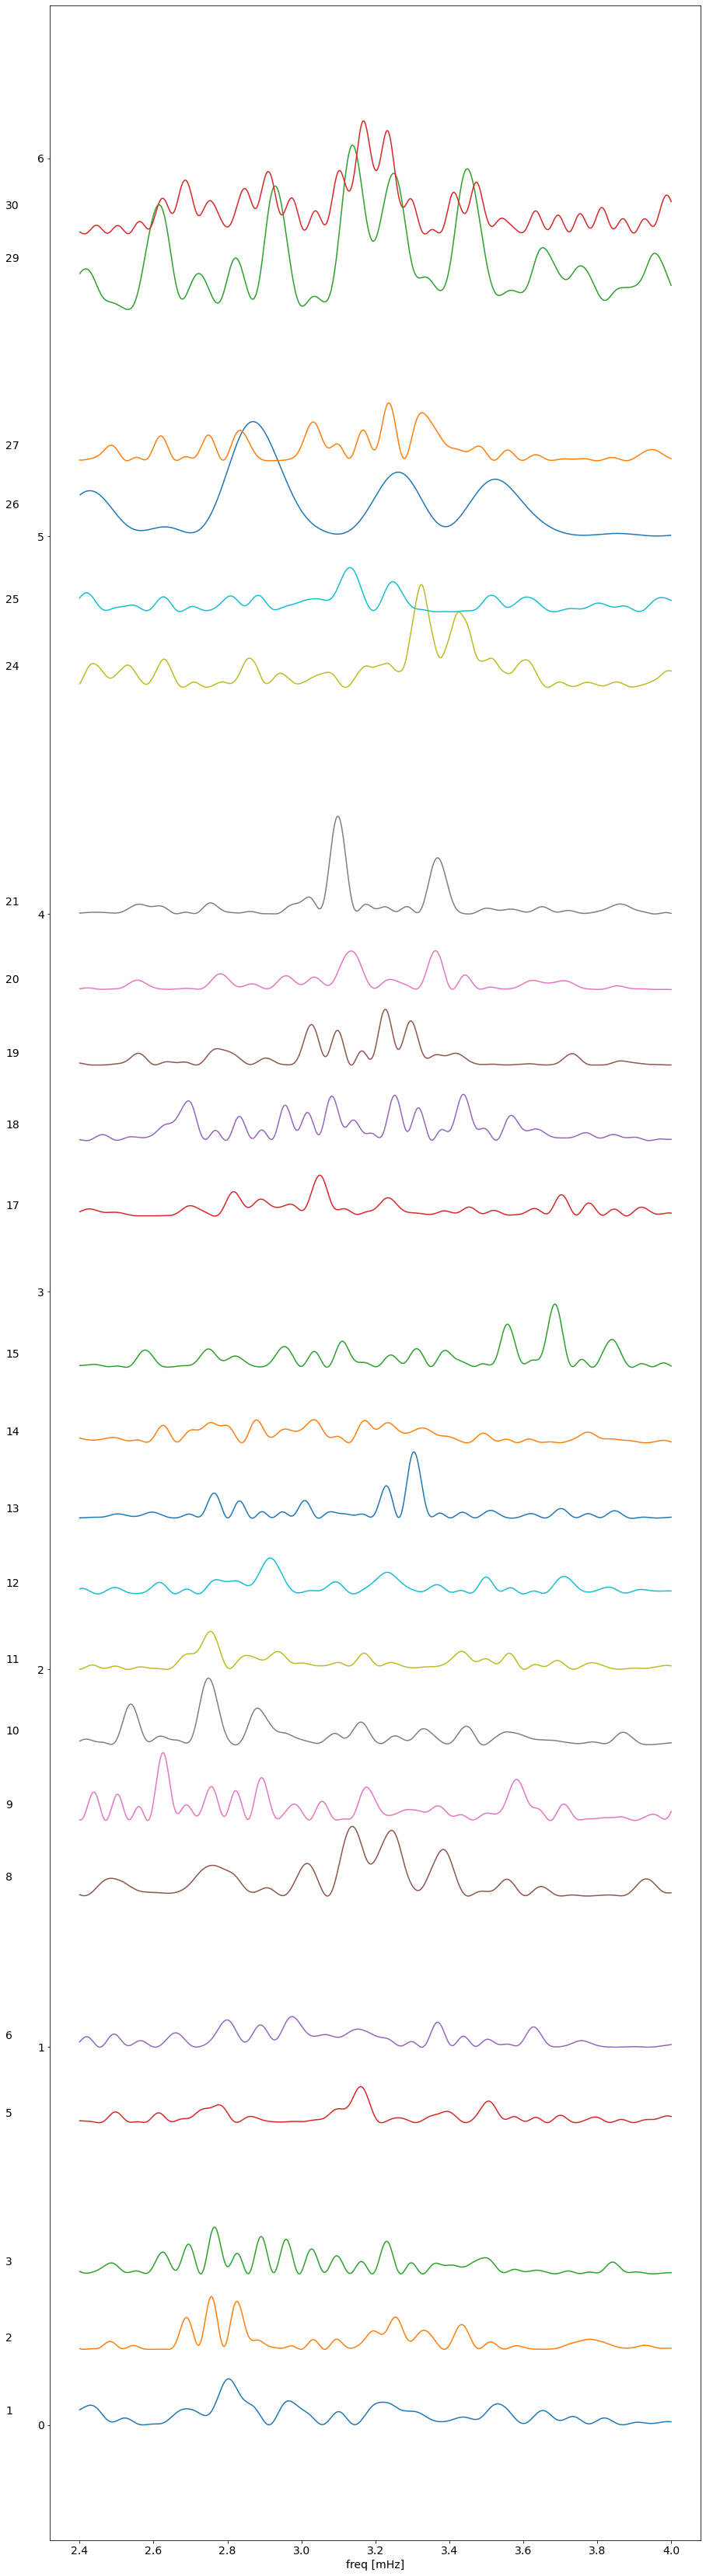

In [50]:
plt.subplots(figsize=(15, 60))
plt.rcParams.update({'font.size': 14})

for t in range(30):
    T1 = pyasl.jdcnv(datetime(2021, 6, t+1))
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    if sum(bjd[idx_bjd])!=0:
        frequency, power = LombScargle(bjd[idx_bjd]*24*60, RV_gauss[idx_bjd], σrv[idx_bjd]).autopower(minimum_frequency=1/(24*60*30), maximum_frequency=1, samples_per_peak=100)        
        idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
        plt.plot(frequency[idx]/60*1000, power[idx]+0.2*t)
        plt.text(2.2, np.mean(power[idx]+0.2*t), str(t+1))
        plt.xlabel('freq [mHz]')
plt.show()

### May

In [34]:
T1      = pyasl.jdcnv(datetime(2021, 5, 1))
T2      = pyasl.jdcnv(datetime(2021, 5, 31))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

frequency, power = LombScargle(bjd[idx_bjd]*24*60, shift_function[0,idx_bjd], err_shift_spectrum[0,idx_bjd]).autopower(minimum_frequency=1/(24*60*30), maximum_frequency=1, samples_per_peak=100)        


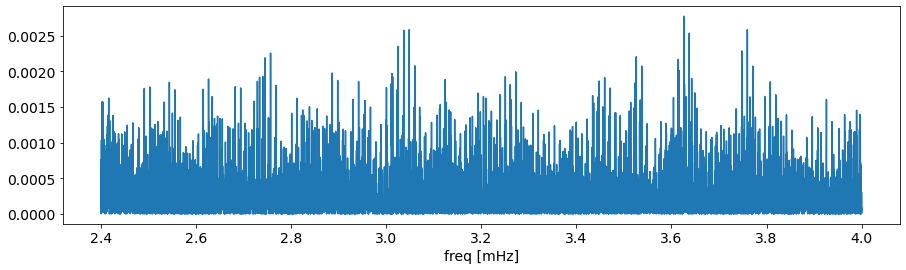

In [35]:
plt.subplots(figsize=(15, 4))
# plot_x = 1/frequency
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx])
# plt.xscale('log')
plt.xlabel('freq [mHz]')
plt.show()

### June

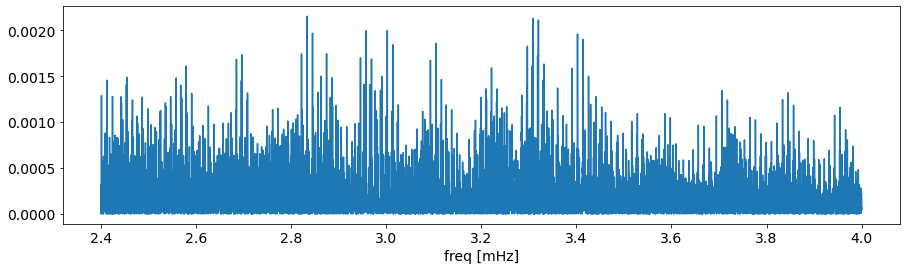

In [36]:
T1      = pyasl.jdcnv(datetime(2021, 6, 1))
T2      = pyasl.jdcnv(datetime(2021, 6, 30))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

frequency, power = LombScargle(bjd[idx_bjd]*24*60, shift_function[0,idx_bjd], err_shift_spectrum[0,idx_bjd]).autopower(minimum_frequency=1/(24*60*30), maximum_frequency=1, samples_per_peak=100)        

plt.subplots(figsize=(15, 4))
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx])
plt.xlabel('freq [mHz]')
plt.show()


### Jan - June

In [37]:
T1      = pyasl.jdcnv(datetime(2021, 1, 1))
T2      = pyasl.jdcnv(datetime(2021, 6, 30))
idx_bjd = (bjd>T1) & (bjd<T2+1) & (~idx_rej)

frequency, power = LombScargle(bjd[idx_bjd]*24*60, shift_function[0,idx_bjd], err_shift_spectrum[0,idx_bjd]).autopower(minimum_frequency=1/(24*60*30), maximum_frequency=1, samples_per_peak=100)        



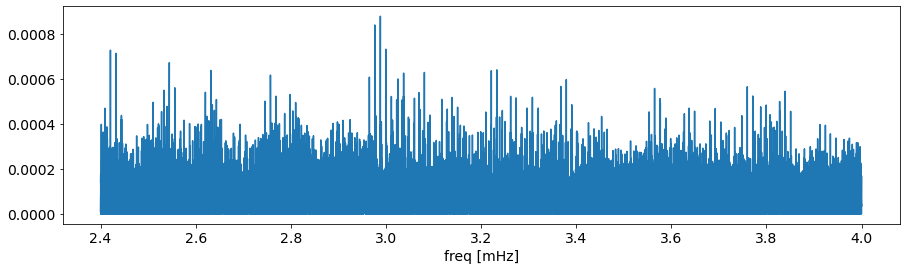

In [38]:
plt.subplots(figsize=(15, 4))
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx])
# plt.xscale('log')
plt.xlabel('freq [mHz]')
plt.show()

### 2021

In [39]:
idx_bjd = (~idx_rej)

frequency, power = LombScargle(bjd[idx_bjd]*24*60, shift_function[0,idx_bjd], err_shift_spectrum[0,idx_bjd]).autopower(minimum_frequency=1/(24*60*30), maximum_frequency=1, samples_per_peak=100)        



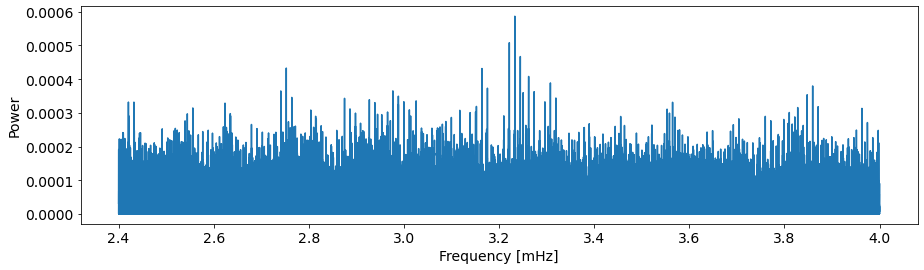

In [41]:
plt.subplots(figsize=(15, 4))
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx], 'k')
# plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency [mHz]')
plt.show()